In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [4]:
%load_ext autoreload
%autoreload

### Read Data

In [5]:
%%time
train_agg = read_file(f"../{PROCESSED_DATA_PATH}/v2/train_agg.pkl")

Shape of data: (458913, 4083)
CPU times: user 4.04 s, sys: 13.8 s, total: 17.9 s
Wall time: 25.8 s


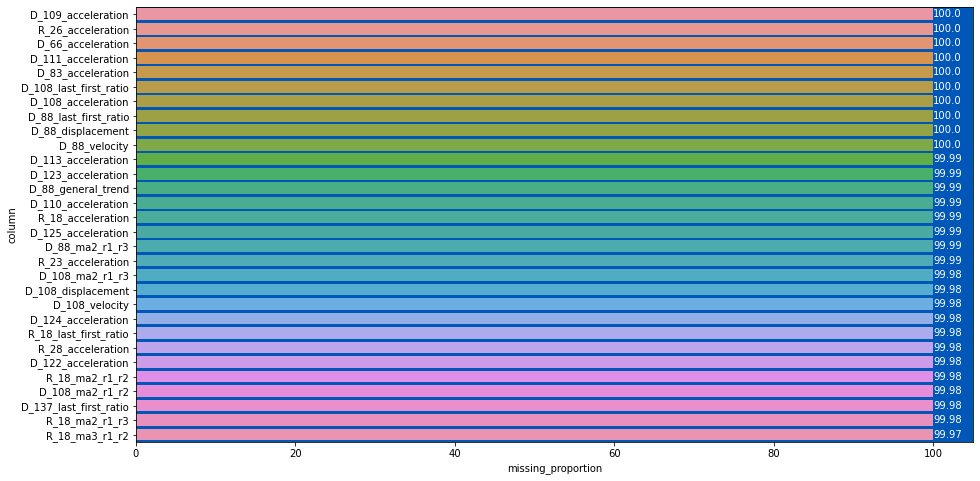

In [6]:
m = plot_missing_proportion_barchart(train_agg)

In [7]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [8]:
high_missing_columns = m.loc[m["missing_proportion"] > 99]["column"].tolist()
len(high_missing_columns)

227

In [9]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 1.24 s, sys: 7.21 s, total: 8.45 s
Wall time: 13.4 s


In [10]:
train_agg.shape

(458913, 3856)

### Pre-train Feature Reduction

In [11]:
def select_noob_features(feature_imp_df, threshold):
    noob_features = []
    for type_ in feature_imp_df.columns[1:]:
        noob_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    print(len(noob_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return noob_features

In [12]:
def get_feature_imp_percentile(summary_df, p):
    array = pd.Series(np.stack(summary_df.drop(columns="base_feature", errors="ignore").values).ravel()).dropna().values
    return np.percentile(array, p)

In [13]:
# features_to_drop = set()
# for i, threshold_percentile in zip(range(5, 10), repeat(10)):
#     print(f"Read file {i}")
#     summary_feature_imp = read_file(f"../{EXP_PATH}/feature_imp_summary{i}.csv")
#     feature_imp_thr = get_feature_imp_percentile(summary_feature_imp, threshold_percentile)
#     # feature_imp_thr = 2
#     drop_feature_subset = set(select_noob_features(summary_feature_imp, feature_imp_thr))
#     features_to_drop = features_to_drop.union(drop_feature_subset)
#     print(f"Threshold = {feature_imp_thr:.2f}, Dropping # of features {len(drop_feature_subset)}")

In [14]:
# Get previous experiment feature importance
feature_imp_df = read_file(f"../{EXP_PATH}/2.lgbm_dart_1020/feature_importance.csv")

Shape of data: (184, 24)


In [15]:
good_features = []
for type_ in feature_imp_df.columns[1:]:
    good_features.extend(
        (
            feature_imp_df.loc[feature_imp_df[type_] > 2]["base_feature"] + "_" + type_
        ).tolist()
    )

In [16]:
len(good_features)

3028

In [17]:
# %%time
# train_agg = train_agg.drop(columns=list(features_to_drop), errors="ignore")
# train_agg.shape

In [18]:
%%time
train_agg = train_agg.loc[:, good_features]
train_agg.shape

CPU times: user 397 ms, sys: 2.49 s, total: 2.89 s
Wall time: 4.29 s


(458913, 3028)

In [19]:
target = labels["target"].values

In [20]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 438 ms, sys: 2.5 s, total: 2.93 s
Wall time: 4.27 s


10295

In [21]:
cat_columns = train_agg.select_dtypes("category").columns.to_list()

In [22]:
train_agg.shape, target.shape

((458913, 3028), (458913,))

### Train LGBM using pre-set hyperparams

In [23]:
seed = 6666

In [24]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': seed,
    'num_leaves': 90,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_freq': 10,
    'bagging_fraction': 0.55,
    'n_jobs': -1,
    'lambda_l2': 20,
    'min_data_in_leaf': 120,
    'scale_pos_weight': 1.35
}

In [25]:
oof_predictions = np.zeros(len(train_agg))

In [26]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [27]:
target = labels["target"].values

In [28]:
cat_features = train_agg.select_dtypes("category").columns
cat_features

Index(['B_30_first', 'B_38_first', 'D_114_first', 'D_117_first', 'D_120_first',
       'D_126_first', 'D_63_first', 'D_64_first', 'D_68_first', 'B_38_last',
       'D_114_last', 'D_117_last', 'D_120_last', 'D_126_last', 'D_63_last',
       'D_64_last', 'D_68_last', 'B_30_second_last', 'B_38_second_last',
       'D_114_second_last', 'D_117_second_last', 'D_120_second_last',
       'D_126_second_last', 'D_63_second_last', 'D_64_second_last',
       'D_68_second_last'],
      dtype='object')

In [30]:
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg, target)):
    if fold != 0:
        break
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {train_agg.shape[1]} features...')
    print('-'*50)
    x_train, x_val = train_agg.iloc[trn_ind], train_agg.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features.tolist())
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features.tolist())
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 10000,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 1000,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'./models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    # # Add to out of folds array
    # oof_predictions[val_ind] = val_pred
    # Predict the test set
    # test_pred = model.predict(test[features])
    # test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 3028 features...
--------------------------------------------------
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.894463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485676
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 3028
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[1000]	training's binary_logloss: 0.259518	training's amex: 0.786689	valid_1's binary_logloss: 0.265656	valid_1's amex: 0.7701
[2000]	training's binary_logloss: 0.215648	training's amex: 0.811208	valid_1's binary_logloss: 0.229154	valid_1's amex: 0.783525
[3000]	training's binary_logloss: 0